# IBD Survey Data Import, Munging and Initial Exploration

In [176]:
from IPython.display import display_html
import numpy as np
import pandas as pd
import scipy
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns


# create the database and tables, and import data
# %run db_builder.py

query = """SELECT uf.user_id, foods.name, uf.prep_id, uf.rating, uf.unknown
FROM users_to_foods uf, foods
WHERE uf.food_id = foods.id"""


# import data
conn = sqlite3.connect('food_db.db')
df = pd.read_sql(query, conn)

# default formatting for values
# pd.options.display.float_format = '{:,.0f}'.format
# pd.reset_option("^display")

def display_side_by_side(*args):
    # displays dfs side-by-side
    html_str=''
    for df in args:
        try:
            html_str+=df.to_html()
        except AttributeError:
            df2= pd.DataFrame(df)
            html_str+=df2.to_html()
    display_html(html_str.replace('table','table style="display:inline; padding: 10px"'),raw=True)  


# confirm the number or rows (questions presented to users, in total) 
print('Number of questions presented to users: {0}'.format(df.shape[0]))

Number of questions presented to users: 151899


With the data in a dataframe, we can pivot the data so each row represents a person's survey answers and we can see the number of participants. However, pivoting initially fails with coulmn set to 'name', since two names weren't unique. 'Pumpkin' was used for both pumpkin as a vegetable and pumpkin seed. 'Squash' was similarly used to reflect both the vegetable and the drink. Manually adjusted the names (to 'Pumpkin seed' and 'Squash (drink)', respectively) to prevent confusion and allow the intended pivot without accidentally aggregating answers to very different survey questions yields:

In [177]:
print(df.columns)
df_pivot = df.pivot(index='user_id', columns='name')
df_pivot.tail()

Index(['user_id', 'name', 'prep_id', 'rating', 'unknown'], dtype='object')


prep_id                                                       \
name    Agave Nectar Almond Almond Milk Anchovy Apple Apple Juice Apricot   
user_id                                                                     
3547             NaN    NaN         0.0     0.0   NaN         NaN     NaN   
3558             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3559             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3563             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3566             0.0    0.0         0.0     0.0   0.0         0.0     0.0   

                                             ...          unknown             \
name    Artichokes Asparagus Aspartame       ...       Watercress Watermelon   
user_id                                      ...                               
3547           NaN       NaN       NaN       ...              NaN        NaN   
3558           0.0       0.0       0.0       ...              0.0        0.0   
3559           0.0       0.0       0.0       ...              1.0        0.0   
3563           0.0       0.0       0.0       ...              1.0        0.0   
3566           0.0       0.0       0.0       ...              1.0        0.0   

                                                               \
name    Wheat Whiskey Wine - Champagne Wine - Pink Wine - Red   
user_id                                                         
3547      0.0     NaN              NaN         NaN        NaN   
3558      0.0     0.0              0.0         0.0        0.0   
3559      1.0     1.0              0.0         0.0        1.0   
3563      0.0     0.0              0.0         0.0        0.0   
3566      0.0     0.0              0.0         0.0        0.0   

                                                       
name    Wine - Sparkling Wine - White Yoghurt - Plain  
user_id                                                
3547                 NaN          NaN             0.0  
3558                 0.0          0.0             0.0  
3559                 0.0          0.0             0.0  
3563                 0.0          0.0             0.0  
3566                 0.0          0.0             0.0  

[5 rows x 750 columns]

Some NaNs already appear in the table, which most likely means that not all food questions were asked for all surveys. My supposition is that there were multiple iterations of the survey all stored in the data table without a column to label the survey number. Let's see how many surveys there were and what the size of each survey was:

In [178]:
q_count = {}
for i in df_pivot.isnull().sum(axis=1).sort_values(ascending=False):
    key = str(int((df_pivot.shape[1] - i)/3)) + '-question'  # divide by 3 to reflect the # of hierarchically indexed columns
    if key in q_count:
        q_count[key] += 1
    else:
        q_count[key] = 1

for k, v in q_count.items():
    print (k,'survey count: ', v)

40-question survey count:  29
61-question survey count:  14
80-question survey count:  24
125-question survey count:  8
164-question survey count:  16
199-question survey count:  8
249-question survey count:  1
250-question survey count:  570


We may still be able to use all of the data from the various iterations of the survey for analysis not sensitive to missing values, but for now we will limit our core data set to only the latest 250-question version of the exam, which leaves ~85% of the initial surveys (570/670).

In [179]:
df_old_surveys = df_pivot.loc[pd.isnull(df_pivot).any(1),:]
print('Confirmed number of old surveys, which are excluded (and saved for later): {0}'.format(df_old_surveys.shape[0]))
df_new_surveys = df_pivot.dropna()
print('Confirmed number of new surveys, which are included: {0}'.format(df_new_surveys.shape[0]))
df_new_surveys.tail()

Confirmed number of old surveys, which are excluded (and saved for later): 100
Confirmed number of new surveys, which are included: 570


prep_id                                                       \
name    Agave Nectar Almond Almond Milk Anchovy Apple Apple Juice Apricot   
user_id                                                                     
3544             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3558             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3559             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3563             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3566             0.0    0.0         0.0     0.0   0.0         0.0     0.0   

                                             ...          unknown             \
name    Artichokes Asparagus Aspartame       ...       Watercress Watermelon   
user_id                                      ...                               
3544           0.0       0.0       0.0       ...              0.0        0.0   
3558           0.0       0.0       0.0       ...              0.0        0.0   
3559           0.0       0.0       0.0       ...              1.0        0.0   
3563           0.0       0.0       0.0       ...              1.0        0.0   
3566           0.0       0.0       0.0       ...              1.0        0.0   

                                                               \
name    Wheat Whiskey Wine - Champagne Wine - Pink Wine - Red   
user_id                                                         
3544      0.0     0.0              0.0         0.0        0.0   
3558      0.0     0.0              0.0         0.0        0.0   
3559      1.0     1.0              0.0         0.0        1.0   
3563      0.0     0.0              0.0         0.0        0.0   
3566      0.0     0.0              0.0         0.0        0.0   

                                                       
name    Wine - Sparkling Wine - White Yoghurt - Plain  
user_id                                                
3544                 0.0          0.0             0.0  
3558                 0.0          0.0             0.0  
3559                 0.0          0.0             0.0  
3563                 0.0          0.0             0.0  
3566                 0.0          0.0             0.0  

[5 rows x 750 columns]

Surveys appear to have values of 0 for both a filled in answer of never being able to eat a food, and when the participant decided not to answer the question. We can remove questions that participants decided not to answer based on a 1 (True) value for the "unknown" column. ((This will result in NaN values in our dataframe.))

In [180]:
df_unpivot = df_new_surveys.stack().reset_index()
df_answered = df_unpivot[df_unpivot.unknown != 1 ]
df_answered_pivot = df_answered.pivot(index='user_id', columns='name', values='rating')
print('{0} questions weren\'t answered.'.format(int(df_answered_pivot.isnull().sum().sum())))
df_answered_pivot.tail()

53429 questions weren't answered.


name,Agave Nectar,Almond,Almond Milk,Anchovy,Apple,Apple Juice,Apricot,Artichokes,Asparagus,Aspartame,...,Watercress,Watermelon,Wheat,Whiskey,Wine - Champagne,Wine - Pink,Wine - Red,Wine - Sparkling,Wine - White,Yoghurt - Plain
user_id,,,,,,,,,,,,,,,,,,,,,
3544,NaN,10.0,NaN,10.0,4.0,0.0,5.0,10.0,10.0,NaN,...,10.0,10.0,2.0,9.0,2.0,1.0,2.0,1.0,0.0,10.0
3558,6.0,6.0,10.0,8.0,4.0,4.0,4.0,9.0,7.0,6.0,...,4.0,6.0,1.0,2.0,3.0,3.0,6.0,3.0,3.0,3.0
3559,NaN,10.0,NaN,NaN,10.0,0.0,NaN,7.0,7.0,4.0,...,NaN,9.0,NaN,NaN,5.0,6.0,NaN,6.0,7.0,9.0
3563,NaN,7.0,7.0,NaN,6.0,NaN,NaN,NaN,6.0,NaN,...,NaN,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3566,NaN,NaN,NaN,NaN,5.0,NaN,6.0,NaN,NaN,NaN,...,NaN,10.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


That's a really high number of questions that weren't answered. Let's dig into which questions went unanswered the most:

In [181]:
# counts of unanswered question by food, sorted most to least
# can compare the % answered from the new and old surveys to help improve the survey responses
possible = df_answered_pivot.shape[0]
unanswered_count = df_answered_pivot.isnull().sum().sort_values(ascending=False)
unanswered_percent = unanswered_count.divide(possible)*100
unanswered = pd.DataFrame({'unanswered_count': unanswered_count, 'unanswered_percent': unanswered_percent})
unanswered['unanswered_percent'] = unanswered['unanswered_percent'].map('{:,.2f}%'.format)

display("unanswered.head(10)", "unanswered.tail(10).sort_values('unanswered_percent')")

,unanswered_count,unanswered_percent
name,,
Goose Egg,486,85.26%
Quail Egg,470,82.46%
Rabbit,462,81.05%
Goose,445,78.07%
Herring,442,77.54%
Veal,439,77.02%
Hazelnut Milk,437,76.67%
Rice Milk,436,76.49%
Oysters,434,76.14%


The least answered survey questions (left table above) seem to be less commonly eaten foods, such as goose eggs and quail eggs, which makes sense - users can't answer if they can eat a food if they haven't tried it before. Conversely, and supporting that conclusion, the most answered survey questions (right table above) all seem to be more common foods (however, of note, there is no question that was answered by everyone). It also makes sense in the context of the number of question responses on surveys, with the average person only answering 156/250 (62%) of the questions:

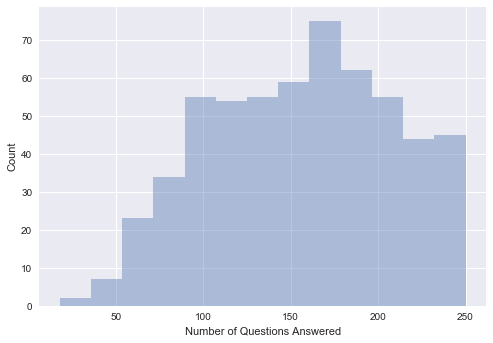

count    570.00
mean     156.26
std       52.75
min       18.00
25%      118.00
50%      158.50
75%      197.00
max      250.00
dtype: object
NormaltestResult(statistic=44.893146580778044, pvalue=1.7847487330974501e-10)


In [182]:
num_answers_per_person = df_answered_pivot.count(axis=1)

# distribution of number of answers per survey
sns.distplot(num_answers_per_person.dropna(), kde=False)
plt.xlabel('Number of Questions Answered')
plt.ylabel('Count')
plt.show()

print(num_answers_per_person.describe().apply('{:,.2f}'.format))
print(scipy.stats.normaltest(num_answers_per_person, nan_policy='omit'))

So the remaining data points seem to accurately reflect our usable data set, but now the quality/usability of that data is called into doubt. Before we clean up the data further (decide how to handle NaNs), we need to assess what type of data we're working with (measurement scale), and as a result, the available/appropriate tests we'll be using the data for.

Determining whether our survey results most appropriately reflects interval data (as it was collected) or [discrete] ordinal data (such as in a likert survey) is somewhat challenging in this case, and extremely important.  If we determine that our data is ordinal, parameters such as mean and standard deviation will likely be invalid, and any parametric analyses (generally considered to have more statistical power) based on the normal distribution will be impossible. Rather, rank, median, and range and associated tests will be the extent of our toolkit. The “intervalness” of the data is an attribute of the data, not of the labels. The primary distinguishing factor will be whether the "distance" between responses is equal and meaningful. A few things to consider in our case:
* Is the distance between 0 and 1 (never eat and very rarely eat) the same as 1 to 2? You can eat infinitely more of a food at 1 than 0...Also, how can you even measure the distance from always to anything less than always? The step always seems like it has to be near infinite (obviously this whole discussion is limited by the normal quantities of food people can/want to eat). The answer to this question seems to be that the distances are unequal, leading to the connclusion of ordinal data.
* If the distances between 0 and 1 ARE the same as 1 and 2, there's the presentation of the survey itself to consider. Given that the survey presented a label-less sliding scale for each food, it's difficult to conclude that survey responses would have been given in purposefully equal increments. That said, even without labels, survey partcipants were likely assuming such equal increments in attempting to place the scale. This line of logic gives a fuzzier answer, but seems to side with cautiously attempting to analyze the data assuming interval measurement.
* If by this point we've sided with interval measurement, the question becomes is 0 [never eat; false] a meaningful zero value in this case? If so, could it be a ratio scale?

Even assuming we have interval data, we will still need to assess the standardization (ideally normality) of the probability distributions of our data (or if we can normalize the data ourselves) in order to determine if we can/should run parametric tests. That said, non-parametric tests may still/also be appropriate, given that the data could be better represented by the median as opposed to the mean. 

But first, let's just explore our remaining data set. We'll start by looking at the descriptive statistics for each surveyed food:

In [183]:
# Let's dig a little deaper into what questions were answered:
df_answered_pivot.describe()  # .applymap('{:,.2f}'.format)
# add median, mode, skew, kurtosis

name,Agave Nectar,Almond,Almond Milk,Anchovy,Apple,Apple Juice,Apricot,Artichokes,Asparagus,Aspartame,...,Watercress,Watermelon,Wheat,Whiskey,Wine - Champagne,Wine - Pink,Wine - Red,Wine - Sparkling,Wine - White,Yoghurt - Plain
count,180.000000,448.000000,229.000000,161.000000,550.000000,497.000000,362.000000,198.000000,395.000000,306.000000,...,327.000000,453.000000,516.000000,295.000000,417.000000,414.00000,360.000000,426.000000,433.000000,495.000000
mean,3.227778,4.082589,6.991266,4.968944,5.394545,4.678068,4.240331,3.712121,5.800000,2.728758,...,5.168196,6.278146,4.023256,2.247458,3.429257,3.36715,2.955556,3.286385,3.586605,5.804040
std,4.214673,3.941389,3.853674,4.369529,3.838114,4.015718,3.838171,3.978745,3.881886,3.529030,...,4.052474,3.861242,3.607361,3.482188,3.670360,3.66126,3.621081,3.572134,3.631460,3.971047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,3.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,4.000000,10.000000,5.000000,5.000000,5.000000,4.000000,2.000000,6.000000,1.000000,...,5.000000,7.000000,4.000000,0.000000,2.000000,2.00000,1.000000,2.000000,3.000000,6.000000
75%,8.000000,8.000000,10.000000,10.000000,10.000000,10.000000,7.750000,7.000000,10.000000,5.000000,...,10.000000,10.000000,6.000000,5.000000,6.000000,6.00000,5.000000,6.000000,6.000000,10.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000


At first glance it seems like there are no universally tolerated/untolerated foods:

In [184]:
print('There are no foods that everyone could tolerate.' if question_answer_summary.loc['min'].max() == 0 else 'There ARE foods that everyone could tolerate.')
print('There are no foods that noone could tolerate.' if question_answer_summary.loc['max'].min() == 10 else 'There ARE foods that noone could tolerate.')

There are no foods that everyone could tolerate.
There are no foods that noone could tolerate.


Before taking the analysis further, we should preprocess the data:

# IBD Survey Data Preprocessing

* Feature scaling using MinMaxScaler - effectively just divides by 10 for our data since all surveys had the same options and the min and max are 0 and 10 for all of them, but gives a nice 0 for never and 1 for always.
* Feature selection/reducing dimensionality

In [191]:
# run tests for normality
scipy.stats.normaltest(df_answered_pivot, nan_policy='omit')
# ALSO use scipy.stats.shapiro shapiro-wilk test
# add both w/ p-val to description df
# If the p-val is very small, it means it is unlikely that the data came from a normal distribution. Use 5%.

# also plot histograms for all foods; add normal distribution line

#df_answered_pivot.plot.hist(layout=(125,2))
#plt.show()

# f, axes = plt.subplots(125,2, figsize=(7,7), sharex=True)
# sns.distplot(df_answered_pivot.dropna(), kde=True, color='b', ax=axes)
# plt.show()

for column in df_answered_pivot.columns:
    print(type(column), column)
    sns.distplot(df_answered_pivot[column].dropna())
    plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'hist'